### Codio Activity 10.3: Decomposition

**Estimated time: 45 minutes**

**40 Points**

This activity focuses on performing a decomposition of a time series following the discussion in videos 10.6 - 10.9.  You will build models on time series using statsmodels and its decomposition capabilities.

#### Index

- [Problem 1](#Problem-1)
- [Problem 2](#Problem-2)
- [Problem 3](#Problem-3)
- [Problem 4](#Problem-4)
- [Problem 5](#Problem-5)

### The Data

For this activity, we use a different built in dataset from statsmodels containing monthly measurements of CO2 at the Mauna Loa Observatory in Hawaii.  From the documentation:

```
An Applied Physics Corporation (APC) nondispersive infrared gas analyzer was used to obtain atmospheric CO2 concentrations, based on continuous data (four measurements per hour) from atop intake lines on several towers. Steady data periods of not less than six hours per day are required; if no such six-hour periods are available on any given day, then no data are used that day. Weekly averages were calculated for most weeks throughout the approximately 44 years of record. The continuous data for year 2000 is compared with flask data from the same site in the graphics section
```

Note that the measurements are in monthly steps.  Your goal is to build a model for the co2 measurements using decomposition with statsmodels tools.  We will use both the `STL` and `STLForecast` objects to accomplish this.  

Below, the data is loaded and cleaned up.  

In [56]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

import warnings

warnings.filterwarnings("ignore")

In [57]:
co2 = sm.datasets.get_rdataset("co2")
co2 = co2.data
co2["time"] = pd.to_datetime(co2["time"])
co2 = co2.set_index(pd.date_range("1-1-1959", periods=len(co2), freq="M")).drop(
    "time", axis=1
)

In [45]:
co2.head()

,value
1959-01-31,315.42
1959-02-28,316.31
1959-03-31,316.50
1959-04-30,317.56
1959-05-31,318.13


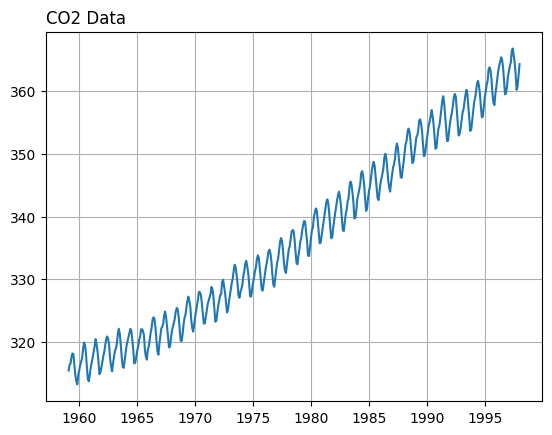

In [46]:
plt.plot(co2)
plt.title("CO2 Data", loc="left")
plt.grid()

[Back to top](#-Index)

### Problem 1

#### Build historical and future datasets

**10 Points**

To begin, split the data at the year 1995.  Observations prior to 1995 will be `y_hist` and values after will be `y_future`.  Uncomment the code to plot your results.  

In [47]:
# y_hist = co2.loc[:"1994", "value"]
# y_future = co2.loc["1995":, "value"]

y_hist = co2[:"1995-01-01"]
y_future = co2["1995-01-01":]

print("Historical type = %s:" % type(y_hist))
print(y_hist.head(3))
print(y_hist.tail(3))

print("Future type = %s:" % type(y_future))
print(y_future.head(3))
print(y_future.tail(3))
type(y_hist)

Historical type = <class 'pandas.core.frame.DataFrame'>:
             value
1959-01-31  315.42
1959-02-28  316.31
1959-03-31  316.50
             value
1994-10-31  356.00
1994-11-30  357.59
1994-12-31  359.05
Future type = <class 'pandas.core.frame.DataFrame'>:
             value
1995-01-31  359.98
1995-02-28  361.03
1995-03-31  361.66
             value
1997-10-31  360.83
1997-11-30  362.49
1997-12-31  364.34


pandas.core.frame.DataFrame

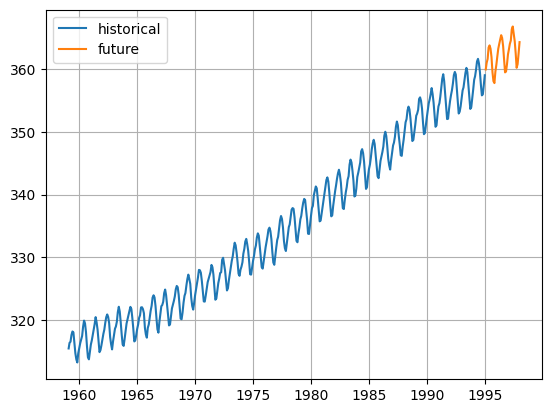

In [48]:
plt.plot(y_hist, label="historical")
plt.plot(y_future, label="future")
plt.legend()
plt.grid()
plt.show()

[Back to top](#-Index)

### Problem 2

#### Extracting the trend

**10 Points**

For our exercise, we will use a built in estimator from statsmodels -- the `STL` model.  To use this model, create an instance of the `STL` estimator and pass `y_hist` and a period value of 12.  

Use the `stl` instance to fit the model, assigning the fit results to `results` below.  This results object will contain the trend as an attribute.  Uncomment the code to see the trend plotted with the original data after fitting.

Text(0.5, 1.0, 'Trend with CO2 Data')

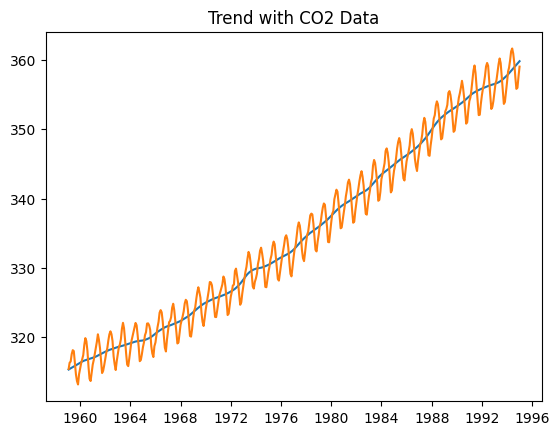

In [49]:
### GRADED

stl = STL(y_hist, period=12)
results = stl.fit()

## Answer check
plt.plot(results.trend)
plt.plot(y_hist)
plt.title("Trend with CO2 Data")

[Back to top](#Index)

### Problem 3

#### Model Historical Data

**10 Points**

As demonstrated in the lectures, additive or multiplicative models can be used to combine the seasonality and trend.  Here, the `results` object is an additive model, meaning that to reproduce our training data involves adding the `.seasonal` attribute to the `.trend` attribute.  Do this below and assign the added season and trend to the variable `season_and_trend` below.  Uncomment the code to view the plot for the last three years of the historical data.



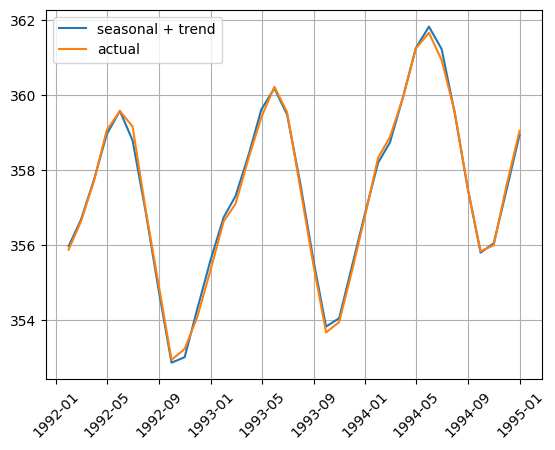

In [50]:
### GRADED
season_and_trend = results.trend + results.seasonal

## Answer Check
plt.plot(season_and_trend["1992":], label="seasonal + trend")
plt.plot(y_hist["1992":], label="actual")
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Problem 4

#### Examining the residuals

**5 Points**

The `results` object also contains information on the residuals in the `.resid` attribute.  Use the plot below to determine if the residuals are stationary or not.  Assign your answer as a string `yes` or `no` to `stationary` below.

Text(0.5, 1.0, 'Stationary or Not?')

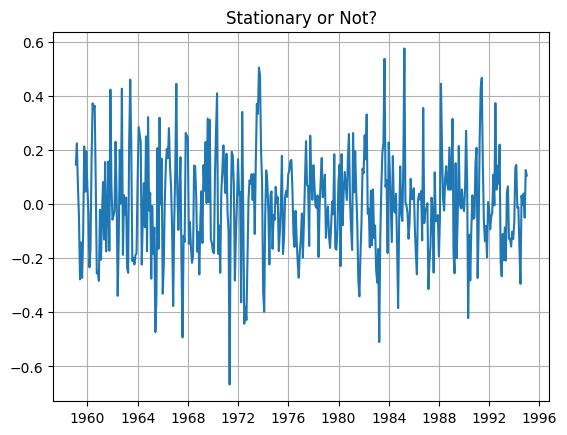

In [51]:
plt.plot(results.resid)
plt.grid()
plt.title("Stationary or Not?")

In [52]:
### GRADED

stationary = "yes"

# Answer check
print(f"Is it stationary: {stationary}")

Is it stationary: yes


[Back to top](#Index)

### Problem 5

#### Examining Error in Forecast

**5 Points**


Finally, to use statsmodels to forecast we will use the `STLForecast` object together with the `ARIMA` model.  This is a model you will discuss in the coming videos, but essentially it helps to extend the trend from the historical data.  Once the estimator is fit on the historical data, a forecast for the future is generated by using the `.forecast` method and passing it the number of time steps forward to project.  

Below, you are to use the `y_future` and `forecast` to determine the prediction error as

```
y_future.value - forecast
```

Use this to compute the Mean Absolute Error and Root Mean Squared Error as `mae` and `rmse` respectively.

In [53]:
# instantiate
stlf = STLForecast(y_hist, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"})
# fit model using historical data
stlf_results = stlf.fit()
# produce forecast for future data
forecast = stlf_results.forecast(len(y_future))

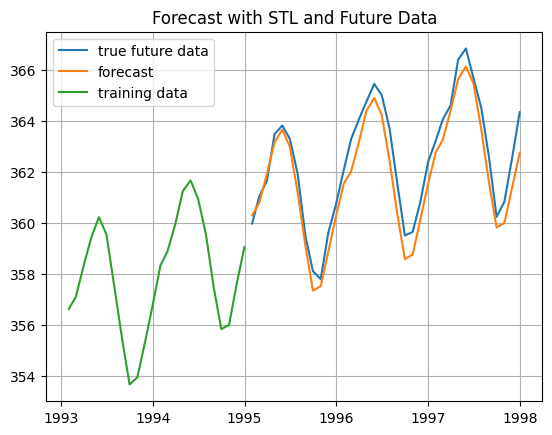

In [54]:
plt.plot(y_future, label="true future data")
plt.plot(forecast, label="forecast")
plt.plot(y_hist["1993":], label="training data")
plt.legend()
plt.title("Forecast with STL and Future Data")
plt.grid()

In [55]:
### GRADED
pred_error = y_future.value - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())

# Answer check
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.6708979300020812
RMSE: 0.7560628531356849
